# Identify Peaks by Derivative

In [1]:
# For scan 6

In [2]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib
import re

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13.75}

matplotlib.rc('font', **font)

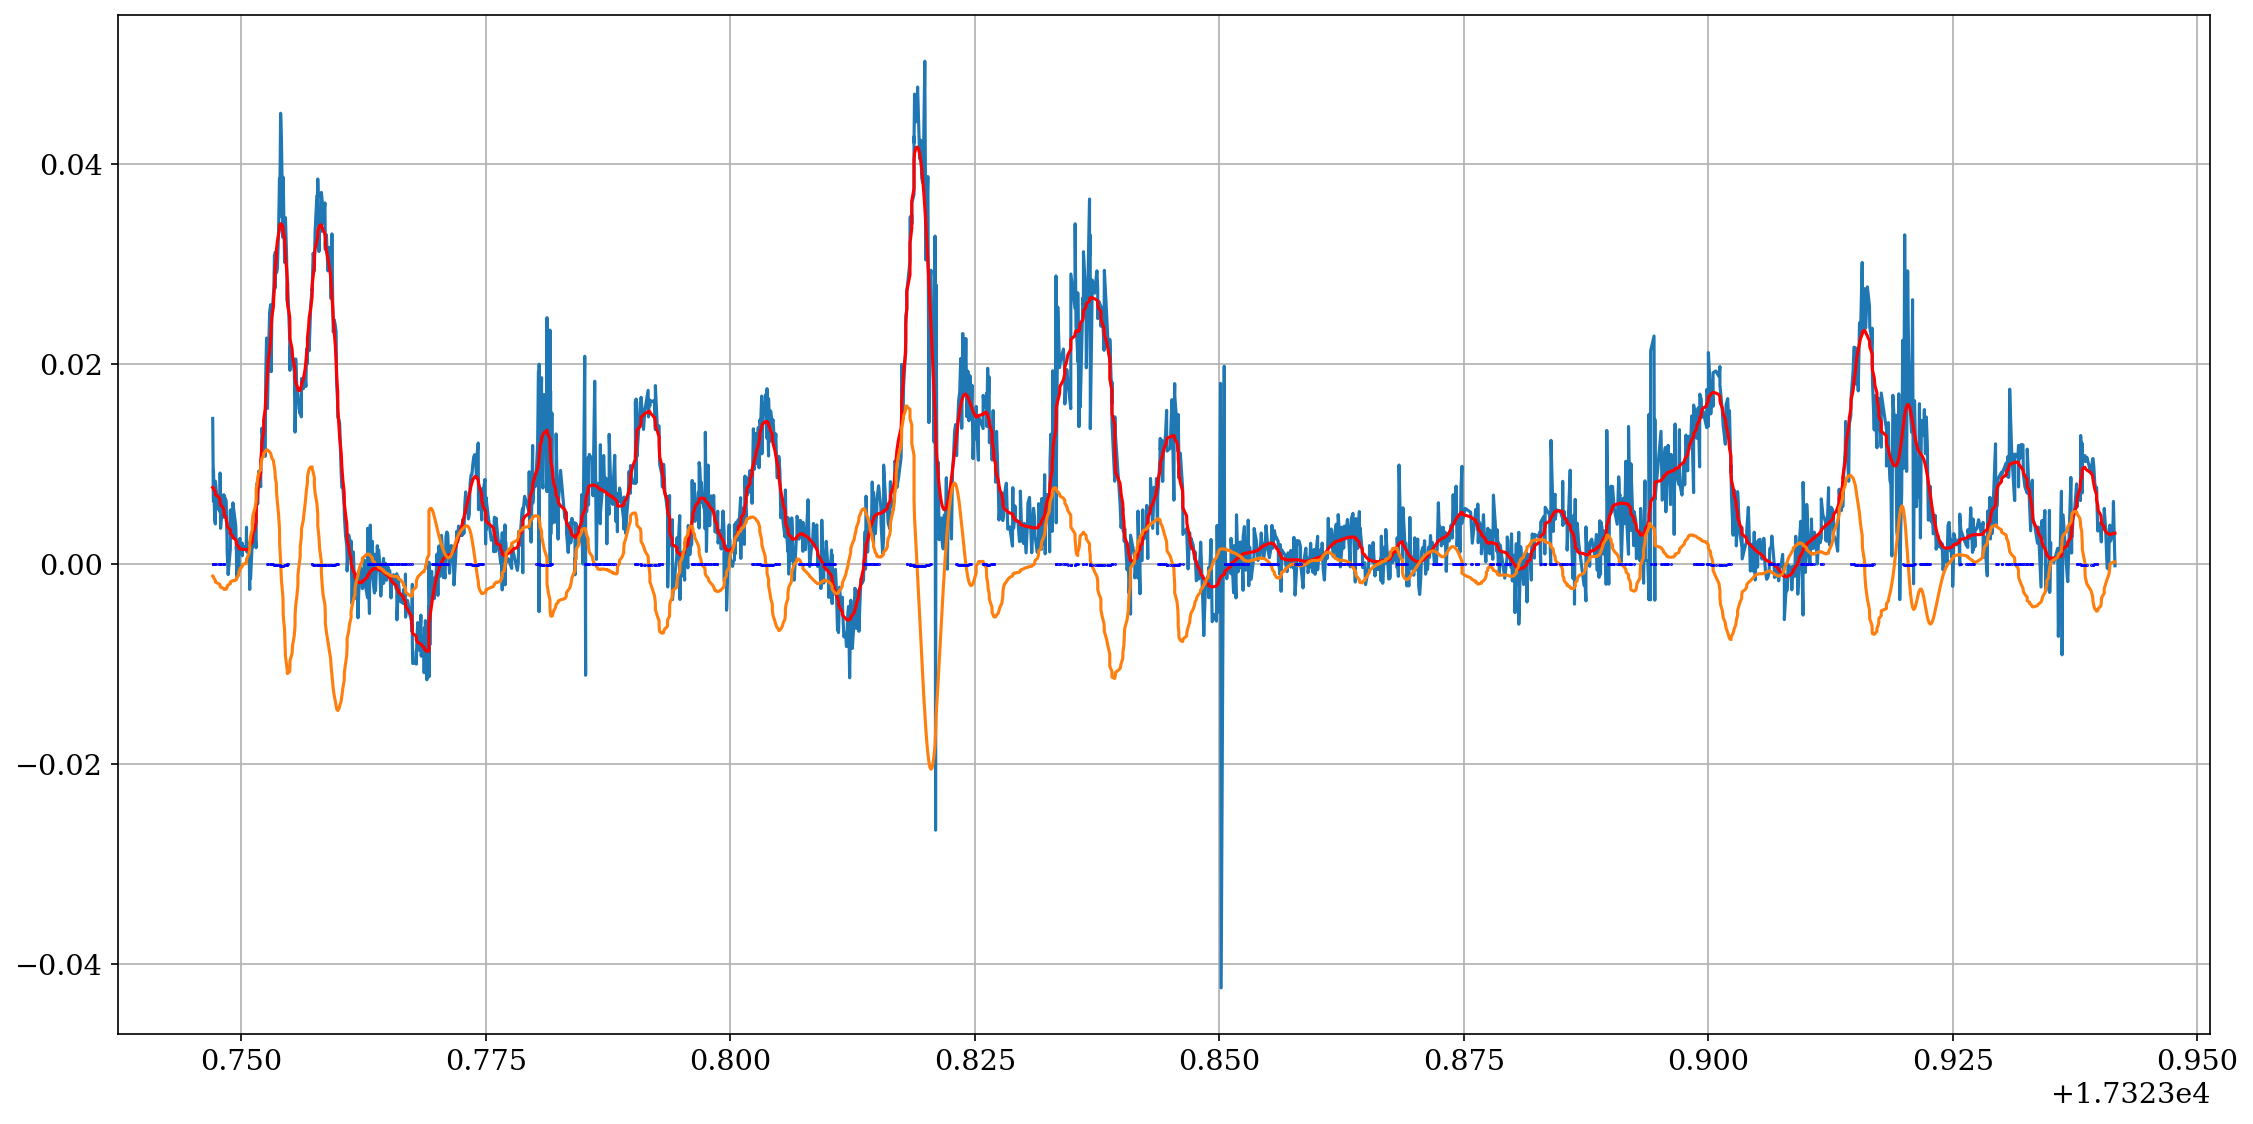

In [3]:
datafile = 'data/20200423_scan6_background_corrected.csv'

k = np.genfromtxt(datafile, delimiter=',')[0:,0][:]
a_nosmooth = np.genfromtxt(datafile, delimiter=',')[0:,1][:]

# Smooth data, take derivative, smooth derivative, take derivative, smooth derivative

a = gaussian_filter1d(a_nosmooth, 5)

#a = savgol_filter(a_nosmooth, 33, 3)
da = gaussian_filter1d(np.gradient(a), 3)
#da = savgol_filter(da, 5, 1)
dda = gaussian_filter1d(np.gradient(da), 3)
#dda = savgol_filter(dda, 25, 3)

fig, ax = plt.subplots(figsize=(18, 9),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

ax.plot(k, a_nosmooth)
ax.plot(k, a, 'r-')
ax.plot(k, da*10, markersize=.5)
ax.plot(k[dda<0], dda[dda<0], 'bo', markersize=.4)
ax.grid(True)
plt.show()

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [751, 752], [940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959], [1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537]]


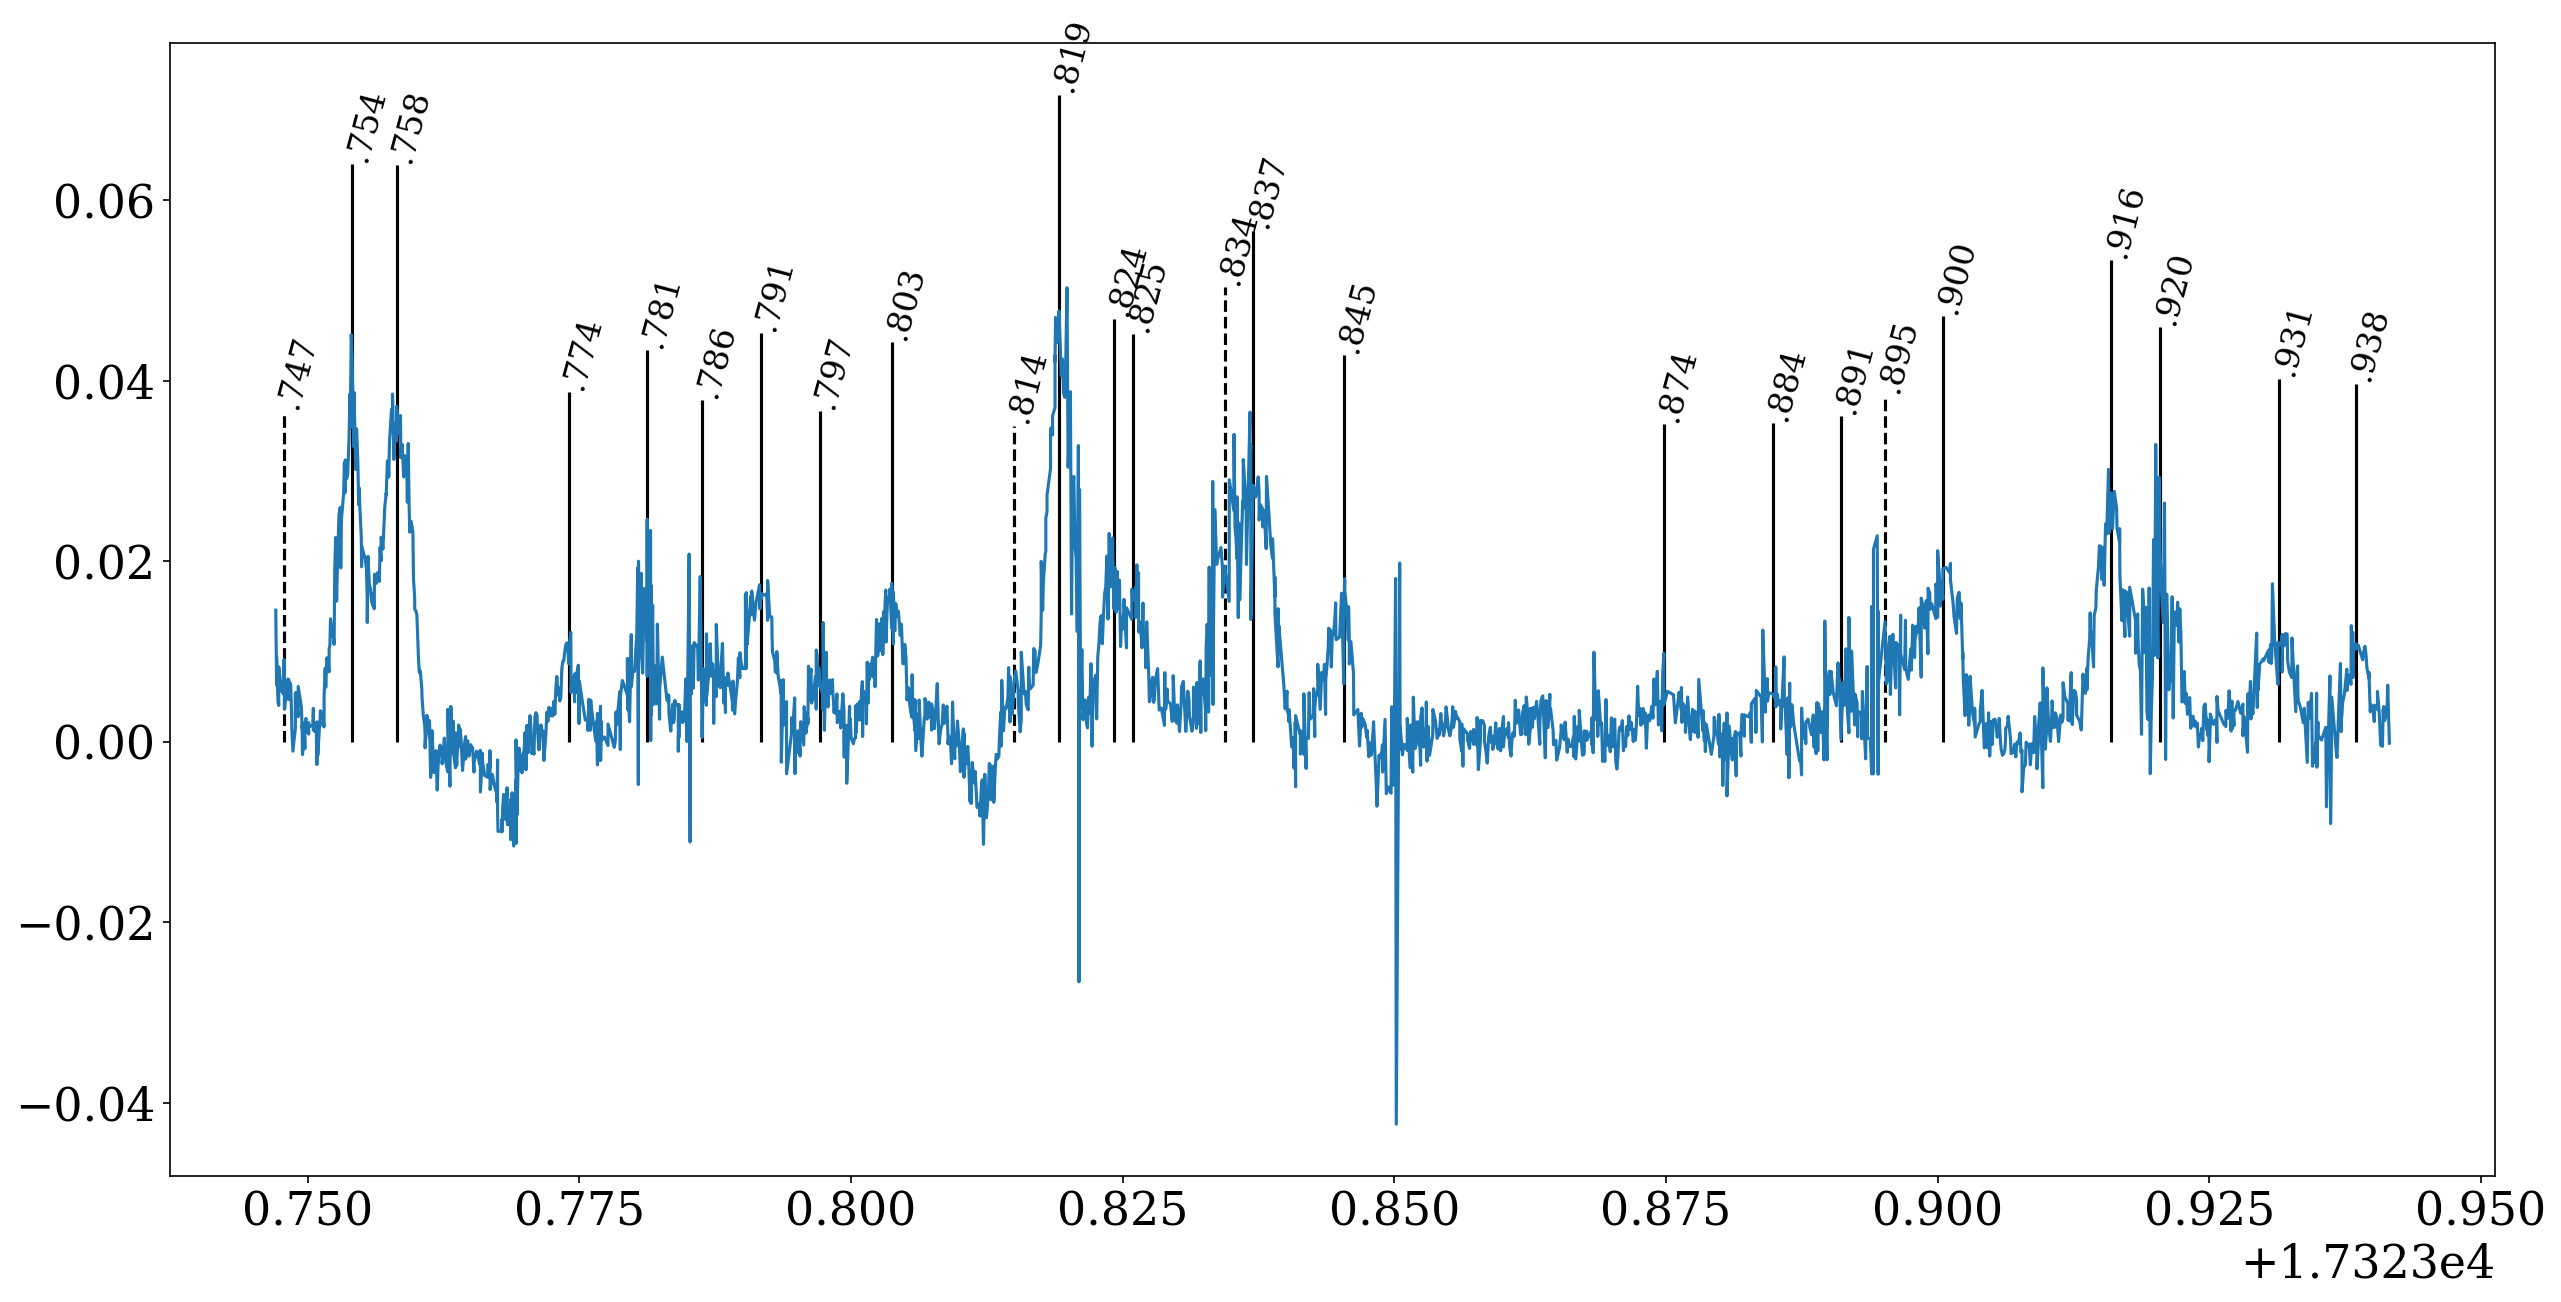

Line wavelengths: 0.7541014538510353, 0.7581880409779842, 0.7740421219496056, 0.781256210331776, 0.7863105402866495, 0.7917039881758683, 0.7971644224053307, 0.8037528603308601, 0.8191532097443996, 0.8241902305890108
Line widths: 0.000469744969450403, 7.829082824173383e-05, 0.0007829082824173383, 0.0007437628682964714


In [4]:
# Find peaks
threshold = .005 # Minimum height of peak
peaks1 = [] # Pretty sure there are peaks here (da goes from + to -)
peaks2 = [] # Not as sure there are peaks here (less sensitive condition: dda < 0)

for i in range(1, len(a)):
    if da[i-1]>0 and da[i]<0 and a[i]>threshold:
        peaks1.append(i)
    if dda[i] < 0 and a[i]>threshold:
        peaks2.append(i)
        
# Average nearby peak locations (could maybe get width from this) (only needed for peaks2)
runs = [[]]
for i in range(1,len(peaks2)):
    if peaks2[i] <= peaks2[i-1]+6:
        runs[-1].append(peaks2[i])
    else:
        runs.append([])
        runs[-1].append(peaks2[i])
        
# Remove runs containing a certain peak1
runs2 = []
for run in runs:
    if set(peaks1).isdisjoint(run) and not run in runs2:
        runs2.append(run)
runs = runs2

print(runs)

peaks2 = [int(mean(run)) for run in runs]
peaks = peaks1 + peaks2

peak_widths = [.5*len(run)*(k[1]-k[0]) for run in runs] #Some ill-defined measure of uncertainty/width. Currently not used

k_peaks1 = k[peaks1]
k_peaks2 = k[peaks2]
k_peaks = k[peaks]

# Plot location and values of lines
fig, ax = plt.subplots(figsize=(20, 10),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

h = .03
ax.plot(k, a_nosmooth)
for i in range(len(peaks1)):
    ax.vlines(k[peaks1[i]], 0, a[peaks1[i]]+h)
    ax.text(k[peaks1[i]]-.001, 
            a[peaks1[i]]+h, str(k[peaks1[i]]-int(k[0]))[1:5], 
            fontsize=16, rotation=75, va='bottom')
for i in range(len(peaks2)):
    ax.vlines(k[peaks2[i]], 0, a[peaks2[i]]+h, linestyle='--')
    ax.text(k[peaks2[i]]-.001, 
            a[peaks2[i]]+h, str(k[peaks2[i]]-int(k[0]))[1:5], 
            fontsize=16, rotation=75, va='bottom')
plt.show()

# Print the first 10 line to compare with Nick
print("Line wavelengths: " + ', '.join(map(str,k_peaks[:10]-int(k_peaks[0]))))
print("Line widths: " + ', '.join(map(str,peak_widths[:10])))  #Not used, should figure out how to do uncertainties

# Dataphile Fitting

In [8]:
# Generate model creator string
creator_string = ''
peaks.sort()

for i in peaks:
    creator_string += "Model(gaussian1D, Parameter(value={amplitude}, bounds=(.0001, .15),  label='amplitude'), Parameter(value={location}, bounds=(min(k)-.01, max(k)+.01), label='center'),Parameter(value=.0012,  bounds=(.0001, .01), label='width'), label='feature_{index}'),".format(location=k[i], amplitude=a[i], index=peaks.index(i))
creator_string += "label='gaussian_peaks')"
creator_string = "model = CompositeModel(" + creator_string


<IPython.core.display.Javascript object>


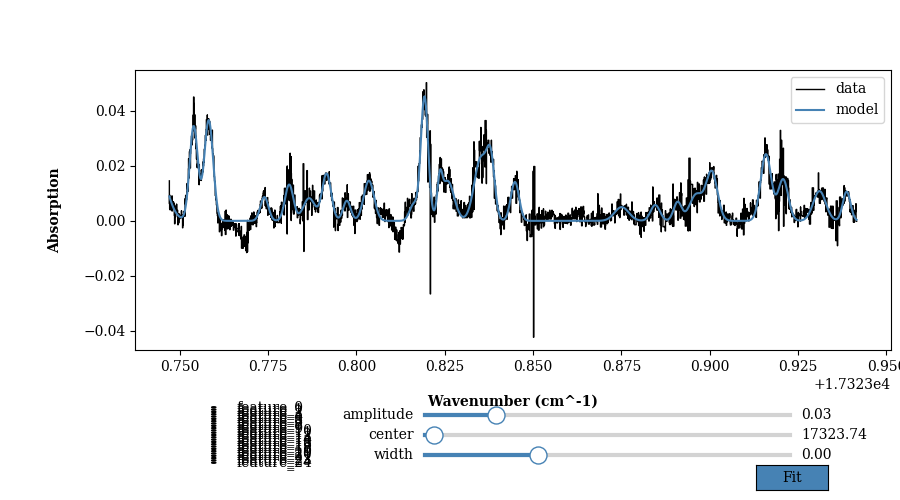

In [9]:
from dataphile.datasets import SyntheticDataset
from dataphile.statistics.distributions import gaussian1D, polynomial1D
from dataphile.statistics.regression.modeling import Parameter, Model, CompositeModel, AutoGUI
from matplotlib import patches
#plt.style.use('seaborn-notebook')
%matplotlib notebook

figure = plt.figure('Absorption Data', figsize=(9, 5))

# create main plot of data
ax_1 = figure.add_axes([0.15, 0.14, 0.84, 0.70])
data_graph, = ax_1.step(k, a_nosmooth, color='black', lw=1, label='data')

# labels
ax_1.set_ylabel('Absorption', labelpad=15, fontweight='semibold')
ax_1.set_xlabel('Wavenumber (cm^-1)', labelpad=15, fontweight='semibold')


# overlay small markers showing location of features
#loc, yloc = x0_s, [(bias + peak).max() + 25 for peak in peaks]
#markers = ax_2.scatter(xloc, yloc, marker='v', color='steelblue')

exec(creator_string)

xsample = np.linspace(min(k), max(k), 1000)
model_graph, = ax_1.plot(xsample, model(xsample), color='steelblue', label='model')
ax_1.legend();

ax_1.set_position([0.15, 0.30, 0.84, 0.56])
gui = AutoGUI(model, [model_graph], bbox=[0.20, 0.07, 0.75, 0.12], figure=figure,
              slider_options={'color': 'steelblue'}, data=(k, a_nosmooth));


In [10]:
model.summary()

value  uncertainty
model      parameter                           
feature_0  amplitude      0.029246     0.178993
           center     17323.742185     0.021563
           width          0.003169     0.006523
feature_1  amplitude      0.034438     0.000897
           center     17323.753967     0.000044
...                            ...          ...
feature_23 center     17323.931067     0.000163
           width          0.001774     0.000165
feature_24 amplitude      0.010662     0.001131
           center     17323.938759     0.000127
           width          0.001095     0.000136

[75 rows x 2 columns]

In [11]:
# Select proper peaks

values0 = np.array([i.values for i in model.models])
uncerts0 = np.array([i.uncertainties for i in model.models])
#values = values0[uncerts0[:,0]/values0[:,0]<.1] # Only take models with fractional amplitude uncertainty < 10 %
#uncerts = uncerts0[uncerts0[:,0]/values0[:,0]<.1] # Could also just take the ones with amplitude above threshold

threshold = .002

values = values0[values0[:,0]>threshold]
uncerts = uncerts0[values0[:,0]>threshold]


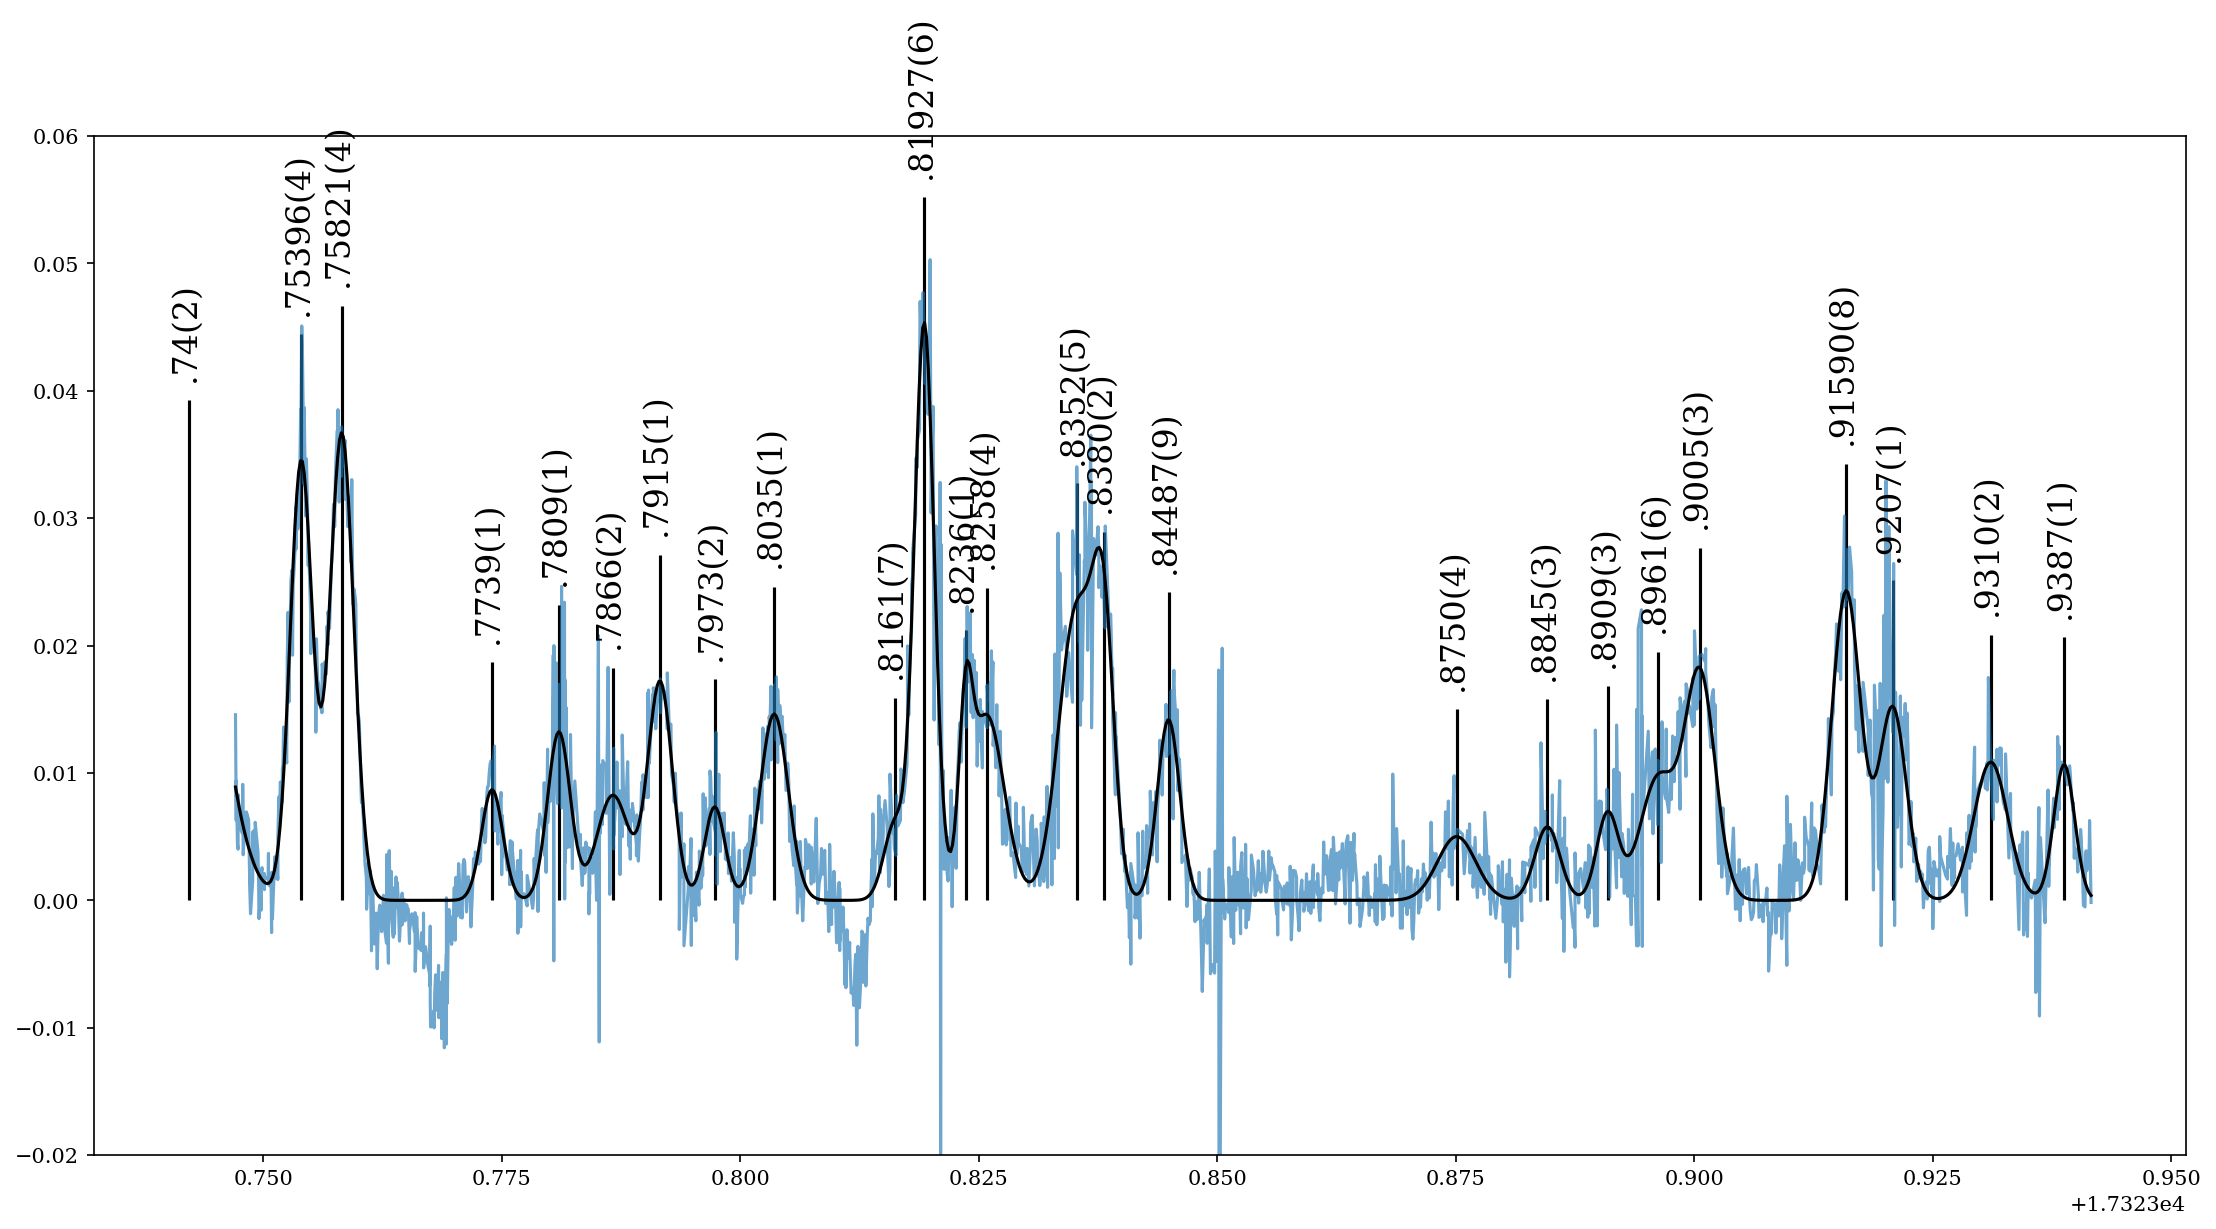

In [20]:
%matplotlib inline

amplitudes = values[0:,0]
k_peaks = values[0:,1]
d_k_peaks = uncerts[0:,1]


fig, ax = plt.subplots(figsize=(18, 9),dpi=150)


ax.plot(k, a_nosmooth, alpha=.65)
h = .01

# Plot location and values of lines
# Most of the complication here is getting the uncertainties displayed correctly
for i in range(len(k_peaks)):    
    ax.vlines(k_peaks[i], 0, amplitudes[i]+h)
    
    if 'e' in str(d_k_peaks[i]):
        n = int(str(d_k_peaks[i])[-1]) - 1
        
        if int(str(d_k_peaks[i])[2]) < 5:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h*1.15, str(k_peaks[i]-int(k[0]))[1:n+3]+'('+str(d_k_peaks[i])[0]+')', 
                fontsize=16, rotation=90, va='bottom')
            
        else:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h*1.15, str(k_peaks[i]-int(k[0]))[1:n+3]+'('+str(int(str(d_k_peaks[i])[0])+1)+')', 
                fontsize=16, rotation=90, va='bottom')
    else:
        s = str(d_k_peaks[i])[2:]
        n = 0
        while s[0]=='0':
            s = s[1:]
            n += 1
            
        if int(str(d_k_peaks[i])[n+3]) < 5:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h*1.15, str(k_peaks[i]-int(k[0]))[1:n+3]+'('+str(d_k_peaks[i])[n+2]+')', 
                fontsize=16, rotation=90, va='bottom')
        else:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h*1.15, str(k_peaks[i]-int(k[0]))[1:n+3]+'('+str(int(str(d_k_peaks[i])[n+2])+1)+')', 
                fontsize=16, rotation=90, va='bottom')
            
model_graph, = ax.plot(xsample, model(xsample), color='black', label='model') #Plot fit
ax.set_ylim([-.02, .06])
plt.savefig("myfits/scan6fit.png")
plt.show()

In [12]:
print(','.join(map(str, k_peaks-17323)))

0.7541014538510353,0.7581880409779842,0.7740421219496056,0.781256210331776,0.7863105402866495,0.7917039881758683,0.7971644224053307,0.8037528603308601,0.8191532097443996,0.8241902305890108,0.8259848401503405,0.837020017694158,0.8453599306340038,0.8748155450011836,0.8848414076273912,0.8911132632056251,0.9004909307368507,0.9160057506596786,0.9204826252062048,0.9314558528094494,0.9385157502292714,0.7478029731864808,0.8149818386154948,0.8344065430064802,0.8951647460489767
